# Финальный проект.
# Промышленность. Предсказание температуры стали.

<a name="1"></a>
## Содержание

1  [Содержание](#1)

2  [Описание проекта и постановка задачи.](#2)

* 2.1  [Описание этапа обработки.](#21)
* 2.2  [Описание данных.](#22)

3  [Предобработка данных](#3)

* 3.1  [Импорт библиотек, загрузка данных, изучение данных.](#31)
* 3.2  [Изучение и подготовка данных.](#32)
  * 3.2.1  [data_arc — данные об электродах](#321)
  * 3.2.2  [data_bulk — данные о подаче сыпучих материалов (объём)](#322)
  * 3.2.3  [data_bulk_time — данные о подаче сыпучих материалов (время)](#323)
  * 3.2.4  [data_gas — данные о продувке сплава газом](#324)
  * 3.2.5  [data_temp — результаты измерения температуры](#325)
  * 3.2.6  [data_wire — данные о проволочных материалах (объём)](#326)
  * 3.2.7  [data_wire_time — данные о проволочных материалах (время)](#327)
  * 3.2.8  [Удаление данных с ошибками.](#328)
  * 3.2.9  [Вывод по данным.](#329)  
* 3.3  [Создание дополнительных признаков.](#33)
  * 3.3.1  [Температура](#331)
  * 3.3.2  [Нагревание](#332)
  * 3.3.3  [Добавление сыпучих и проволочных материалов](#333)
  * 3.3.3  [Вывод по созданным признакам.](#334) 

4  [Исследовательский анализ данных](#4)

* 4.1  [Температура.](#41)
  * 4.1.1  [Начальные данные](#411)
  * 4.1.2  [Измененные данные](#412)
* 4.2  [Нагревание.](#42)
* 4.3  [Добавление сыпучих и проволочных материалов, продувка.](#43)

5  [Подготовка к обучению.](#5)

* 5.1  [Объединение таблиц.](#51)
* 5.2  [Выявление корреляции.](#52)

6  [Обучение и проверка моделей.](#6)

* 6.1  [Подготовка к обучению.](#61)
* 6.2  [LinearRegression.](#62)
* 6.3  [DecisionTreeRegressor.](#63)
* 6.4  [RandomForestRegressor.](#64)
* 6.5  [LightGBM.](#65)
* 6.6  [CatBoost.](#66)
* 6.7  [Сравнение моделей.](#67)
    
7  [Общий вывод.](#7)

<a name="2"></a>
## Описание проекта и постановка задачи.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

<a name="21"></a>
### Описание этапа обработки.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<a name="22"></a>
### Описание данных.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Данные также находятся в тренажёре, в папке /datasets/final_steel/

<a name="3"></a>
## Предобработка данных.

<a name="31"></a>
### Импорт библиотек, загрузка данных, изучение данных.

In [1]:
#!pip3 install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.display import display
#from scipy import stats as st

from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score , train_test_split
from sklearn.tree import DecisionTreeRegressor #,DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor #RandomForestClassifier
from sklearn.linear_model import LinearRegression #,LogisticRegression

from lightgbm import LGBMRegressor #,LGBMClassifier

from catboost import CatBoostRegressor #,CatBoostClassifier


# from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import mean_absolute_error, make_scorer #, mean_squared_error, r2_score, accuracy_score 
                                                             #, f1_score, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data_arc = pd.read_csv('data_arc.csv') #/datasets/final_steel/
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

<a name="32"></a>
### Изучение и подготовка данных.

<a name="321"></a>
#### data_arc — данные об электродах

In [4]:
display(data_arc[2580:2590])
data_arc.info()
data_arc.describe()
print()
print('дубликатов:', data_arc.duplicated().sum())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
2580,561,2019-05-24 04:12:34,2019-05-24 04:14:35,0.436616,0.321434
2581,562,2019-05-24 05:03:27,2019-05-24 05:05:59,0.504374,0.488948
2582,562,2019-05-24 05:10:04,2019-05-24 05:14:42,0.879836,0.830249
2583,562,2019-05-24 05:19:38,2019-05-24 05:25:06,1.257511,0.987964
2584,562,2019-05-24 05:29:09,2019-05-24 05:30:58,0.423316,0.354151
2585,562,2019-05-24 05:36:07,2019-05-24 05:37:30,0.310004,0.246929
2586,563,2019-05-24 05:46:37,2019-05-24 05:48:49,0.461577,0.353200
2587,563,2019-05-24 05:53:09,2019-05-24 05:56:38,0.716747,0.616500
2588,563,2019-05-24 06:04:01,2019-05-24 06:06:51,0.614422,0.438614
2589,563,2019-05-24 06:12:02,2019-05-24 06:14:25,0.508797,0.364086


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

дубликатов: 0


In [5]:
print(data_arc['key'].unique())
print(data_arc['key'].nunique())

[   1    2    3 ... 3239 3240 3241]
3214


In [6]:
 display(data_arc[data_arc['Реактивная мощность']<=0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


***
**Промежуточный вывод:**

*  Значение реактивной мощности партии 2116 отличается на несколько порядков от прочих и единственное меньше нуля - явный выброс.**

*  Cтолбц 'Начало нагрева дугой' и 'Конец нагрева дугой' необходимо перевести в datetime

*  Из времени начала и конца нагрева можно получить длительность нагрева. Умножив на мощность можно получить энергию.

In [7]:
# здесь и далее копии таблиц созданы для возможности вернуть начальные/неизмененные данные без загрузки.
data_arc2 = data_arc.copy()

In [8]:
data_arc2[data_arc2['key']>2114].head(11)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9775,2115,2019-07-24 00:01:00,2019-07-24 00:02:58,0.470668,0.348211
9776,2115,2019-07-24 00:09:25,2019-07-24 00:11:49,0.665501,0.435063
9777,2115,2019-07-24 00:21:20,2019-07-24 00:22:21,0.259949,0.175169
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796
9782,2117,2019-07-24 01:06:01,2019-07-24 01:07:57,0.443970,0.367739
9783,2117,2019-07-24 01:11:41,2019-07-24 01:15:02,0.875074,0.754924
9784,2117,2019-07-24 01:20:10,2019-07-24 01:23:44,0.807190,0.984359


In [9]:
# строку с выбросом и строки соответствующих партийможно было бы удалить, но 
# реактивная мощность вероятно не самый важный признак и остальные признаки в данной партии выглядят нормально
# логично заменить близким по значению активной мощности соседом (без использования KNN)
data_arc2.loc[9780, 'Реактивная мощность']=0.37

In [10]:
data_arc2['Начало нагрева дугой'] = data_arc2['Начало нагрева дугой'].astype('datetime64')
data_arc2['Конец нагрева дугой'] = data_arc2['Конец нагрева дугой'].astype('datetime64')

<a name="322"></a>
#### data_bulk — данные о подаче сыпучих материалов (объём)

In [11]:
display(data_bulk.sample(5))
data_bulk.info()
display(data_bulk.describe())
print()
print('дубликатов:', data_bulk.duplicated().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2760,2864,NaN,NaN,NaN,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,522.0,NaN,234.0,106.0
1983,2053,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,444,52.0,NaN,NaN,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,671.0,NaN,379.0,203.0
142,156,48.0,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,28.0,107.0,NaN,104.0,203.0
1523,1581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413.0,NaN,218.0,206.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



дубликатов: 0


In [12]:
display(data_bulk[data_bulk['Bulk 8']>0])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


***
**Промежуточный вывод:**

*  Признак 'Bulk 8' встречается 1 раз - на нем модель не обучим. Всю партию 1786 и столбец Bulk 8 считаю логичным удалить.

*  Отсутствующие значения можно заменить нулями.

*  Из суммы значений столбцов можно получить признак 'Bulk_sum' - суммарный объем сыпучих матриалов.

In [13]:
data_bulk2 = data_bulk.copy()
data_bulk2 = data_bulk2.drop(['Bulk 8'], axis=1)

data_bulk2 = data_bulk2.fillna(0)
data_bulk2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


<a name="323"></a>
#### data_bulk_time — данные о подаче сыпучих материалов (время)

In [14]:
display(data_bulk_time[1720:1725])
#data_bulk_time.info()
print()
print('дубликатов:', data_bulk_time.duplicated().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1720,1780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-05 14:02:11,NaN,2019-07-05 14:02:11,2019-07-05 14:02:11
1721,1781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-05 14:35:44,NaN,2019-07-05 14:35:44,2019-07-05 14:35:44
1722,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-05 15:12:12,NaN,2019-07-05 15:12:12,2019-07-05 15:12:12
1723,1784,NaN,NaN,2019-07-05 16:27:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-05 16:20:02,NaN
1724,1785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-05 16:52:57,NaN



дубликатов: 0


In [15]:
data_bulk_time2 = data_bulk_time.copy()
data_bulk_time2 = data_bulk_time2.drop(['Bulk 8'], axis=1)

# столбцы с данными по сыпучим материалам
bulk_col_list = list(data_bulk2.select_dtypes(include=['float64']).columns)

# меняем тип столбцов на datetime64
for col in bulk_col_list:
    data_bulk_time2[col] = data_bulk_time2[col].astype('datetime64')
    
#data_bulk_time2.info()

<a name="324"></a>
#### data_gas — данные о продувке сплава газом

In [16]:
display(data_gas[520:525])
data_gas.info()
print()
print('дубликатов:', data_gas.duplicated().sum())

,key,Газ 1
520,523,7.560519
521,524,12.280482
522,525,21.723381
523,526,12.601087
524,527,15.560094


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

дубликатов: 0


In [17]:
data_gas2 = data_gas.copy()

<a name="325"></a>
#### data_temp — результаты измерения температуры

In [18]:
display(data_temp[100:105])
data_temp.info()
display(data_temp.describe())
print()
print('дубликатов:', data_temp.duplicated().sum())

,key,Время замера,Температура
100,19,2019-05-04 01:17:53,1598.0
101,19,2019-05-04 01:18:34,1604.0
102,19,2019-05-04 01:19:06,1597.0
103,20,2019-05-04 01:41:53,1582.0
104,20,2019-05-04 01:51:27,1584.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



дубликатов: 0


In [19]:
data_temp2 = data_temp.copy()
data_temp2['Время замера'] = data_temp2['Время замера'] .astype('datetime64')
data_temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [20]:
# пропуски в значениях температуры
data_temp2[data_temp2['Температура']!=data_temp2['Температура']]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [21]:
# партии с пропусками
nan_key = data_temp2[data_temp['Температура']!=data_temp2['Температура']]['key'].unique()
nan_key.size

739

In [22]:
print('на участке от 2500 до 3241 партии пропуски в', nan_key.size, 'партиях из', 3241-2500)

на участке от 2500 до 3241 партии пропуски в 739 партиях из 741


In [23]:
# партии от 2500 до 3241
data_temp2_NaN = data_temp2[(data_temp2['key']<=3241) & (data_temp2['key']>=2500)]
data_temp2_NaN.head(7)

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [24]:
# количество значений температуры для каждой партии
data_temp2_NaN_count = data_temp2_NaN.pivot_table(index=data_temp2['key'], values='Температура', aggfunc=('count'))
data_temp2_NaN_count

,Температура
key,
2500,1
2501,1
2502,1
2503,1
2504,1
...,...
3237,1
3238,1
3239,1


In [25]:
data_temp2_NaN_count['Температура'].value_counts()

1    739
Name: Температура, dtype: int64

***
**Промежуточный вывод:**

*  пропуски на участке от 2500 до 3241 партии (741 партия), для всех этих партий есть только 1 измеренная температура. Возможно связано с неисправностью измерительного оборудования или ошибкой сбора данных. Необходимо удалить данные по всем партиям от 2500 до 3241 включительно.

*  Для партий 195 и 279 также есть только 1 измеренная температура - необходимо удалить.

In [26]:
data_temp2[data_temp2['Температура']<1400]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [27]:
low_temp_list = data_temp2[data_temp2['Температура']<1400]['key'].unique().tolist()
#low_temp_list

In [28]:
for key in low_temp_list:
    print(data_temp2[data_temp2['key']==key])
    print()  

      key        Время замера  Температура
4350  867 2019-06-04 14:21:00       1191.0
4351  867 2019-06-04 14:29:35       1575.0
4352  867 2019-06-04 14:30:29       1576.0
4353  867 2019-06-04 14:43:10       1571.0
4354  867 2019-06-04 14:52:54       1600.0
4355  867 2019-06-04 14:57:17       1599.0

       key        Время замера  Температура
5978  1214 2019-06-16 05:32:00       1208.0
5979  1214 2019-06-16 05:49:01       1608.0
5980  1214 2019-06-16 05:51:28       1608.0
5981  1214 2019-06-16 05:51:38       1608.0
5982  1214 2019-06-16 05:52:41       1608.0
5983  1214 2019-06-16 05:53:03       1608.0
5984  1214 2019-06-16 05:53:13       1608.0
5985  1214 2019-06-16 05:54:48       1604.0
5986  1214 2019-06-16 05:57:21       1604.0
5987  1214 2019-06-16 06:00:25       1604.0
5988  1214 2019-06-16 06:06:12       1600.0
5989  1214 2019-06-16 06:07:28       1596.0
5990  1214 2019-06-16 06:08:28       1596.0
5991  1214 2019-06-16 06:09:10       1603.0
5992  1214 2019-06-16 06:12:25       1

***
**Промежуточный вывод:**

Согласно открытым источникам минимальная температура плавления стали 1350 (для определенных марок) и выше. Температура на выходе из печи и при процессах в ковше еще выше. Таким образом указанные замеры (менее 1400 градусов)- явный выброс. В пяти случаях ошибка выпадает на первый замер. Причиной может быть наличие газа в области измерительного прибора (при продувке) или сбой оборудования. 

*  Для партий 1619 и 2052 следующие измерения температуры производятся менее чем через минуту - т.о. ошибочный замер можно просто не учитывать и взять в качестве начальной температуры следующее значение. 

*  Для партий 867 и 1214 близких измерений нет. Для партии 1214 есть странные повторяющиеся значения - надежней удалить. 

*  Для партии 1818 ошибочные значения в середине - достаточно удалить.

<a name="326"></a>
####  data_wire — данные о проволочных материалах (объём)

In [29]:
display(data_wire[520:525])
data_wire.info()
display(data_wire.describe())
print()
print('дубликатов:', data_wire.duplicated().sum())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
520,555,168.386399,22.227921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,556,100.151993,15.140320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,557,113.209198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,558,101.181595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,559,105.112801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



дубликатов: 0


In [30]:
display(data_wire[data_wire['Wire 5']>0])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2440,2567,18.30192,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN


***
**Промежуточный вывод:**

*  По аналогии с данными о сыпучих материалах всю партию 2567 и столбец Wire 5 считаю логичным удалить.

*  Отсутствующие значения можно заменить нулями.

*  Из суммы значений столбцов можно получить признак 'Wire_sum' - суммарный объем проволочных матриалов.

In [31]:
data_wire2 = data_wire.copy()
data_wire2 = data_wire2.drop(['Wire 5'], axis=1)

data_wire2 = data_wire2.fillna(0)
data_wire2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 6  3081 non-null   float64
 6   Wire 7  3081 non-null   float64
 7   Wire 8  3081 non-null   float64
 8   Wire 9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


<a name="327"></a>
#### data_wire_time — данные о проволочных материалах (время)

In [32]:
display(data_wire_time[520:525])
data_wire_time.info()
display(data_wire_time.describe())
print()
print('дубликатов:', data_wire_time.duplicated().sum())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
520,555,2019-05-24 00:35:10,2019-05-24 00:38:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,556,2019-05-24 01:31:24,2019-05-24 01:33:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,557,2019-05-24 01:50:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,558,2019-05-24 02:43:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,559,2019-05-24 03:16:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



дубликатов: 0


In [33]:
data_wire_time2 = data_wire_time.copy()
data_wire_time2 = data_wire_time.drop(['Wire 5'], axis=1)

# столбцы с данными по проволочным материалам
wire_col_list = list(data_wire2.select_dtypes(include=['float64']).columns)

# меняем тип столбцов на datetime64
for col in wire_col_list:
    data_wire_time2[col] = data_wire_time2[col].astype('datetime64')
    
data_wire_time2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](8), int64(1)
memory usage: 216.8 KB


***
**Уточнение задачи:**

На основании задачи и данных можно предположить возможность экономии электроэнергии за счет своевременного прекращения нагрева стали дугой или уменьшения мощности на заключительном этапе обработки партии.Модель предсказывающая температуру на основании имеющихся данных позволит решить поставленную задачу.

Таким образом единицей модели будет партия, а целевым признаком температура на заключительном этапе обработки партии (наиболее позднее значение температуры партии).

Предварительно можно выделить следующие факторы, влияющие на конечную температуру:
* начальная температура
* продолжительность и интенсивность нагрева
* продолжительность обработки партии (остывание)
* количество легирующих материалов (возможно как положительное так и отрицательное влияние)
* продолжительность/интенсивность продувки

<a name="328"></a>
#### Удаление данных с ошибками.

In [34]:
data_temp2[data_temp2['key']==867]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0


In [35]:
# удаляем пропуски и выбросы, считаем потери

df_name_list = ['data_arc2', 'data_bulk2', 'data_bulk_time2', 'data_gas2', 'data_temp2', 'data_wire2', 'data_wire_time2']
i=0

for df in [data_arc2, data_bulk2, data_bulk_time2, data_gas2, data_temp2, data_wire2, data_wire_time2]:
    df.name = df_name_list[i]
    df.size_0 = df['key'].unique().size
    df.query('key != 195 and key != 279 and key != 867 and key != 1214 and key != 1786 and key<2500', inplace=True)
    df.size_1 = df['key'].unique().size
    loss = df.size_0 - df.size_1
    print('из', df.size_0, 'партий', loss, '({:.1%})'.format(loss/df.size_0), 'удалили в', df.name)
    i+=1    

из 3214 партий 742 (23.1%) удалили в data_arc2
из 3129 партий 725 (23.2%) удалили в data_bulk2
из 3129 партий 725 (23.2%) удалили в data_bulk_time2
из 3239 партий 747 (23.1%) удалили в data_gas2
из 3216 партий 744 (23.1%) удалили в data_temp2
из 3081 партий 712 (23.1%) удалили в data_wire2
из 3081 партий 712 (23.1%) удалили в data_wire_time2


In [36]:
data_temp2[data_temp2['key']==867]

,key,Время замера,Температура


In [37]:
data_temp2 = data_temp2[data_temp2['Температура'] > 1400]

<a name="329"></a>
#### Вывод по данным.

Входящие данные требуют предобработки. Могут встречаться выбросы, требуется приведение значений дат к нужному формату, есть пропуски и малоинформативные на данный момент признаки (Bulk 8 и Wire 5). 

Для некоторых участков данных нет необходимых измерений. Были удалены данные по следующим партиям: 195, 279, 867, 1214, 1786 и с 2500 по 3241 включительно. Потеряно около 23% данных. 

В таблицах разное количество партий.

<a name="33"></a>
### Создание дополнительных признаков.

<a name="331"></a>
#### Температура.

In [38]:
data_temp2 = data_temp2.sort_values(by='Время замера')

In [39]:
data_temp_by_key = data_temp2.pivot_table(index=data_temp2['key'], aggfunc={'Время замера': ('count', 'first', 'last'), 
                                                                            'Температура': ('first', 'last', list)}) #list

In [40]:
data_temp_by_key.head(3)

Время замера                                         Температура          \
           count               first                last       first    last   
key                                                                            
1              5 2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0  1613.0   
2              6 2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0  1602.0   
3              5 2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0  1599.0   

                                                       
                                                 list  
key                                                    
1            [1571.0, 1604.0, 1618.0, 1601.0, 1613.0]  
2    [1581.0, 1577.0, 1589.0, 1604.0, 1608.0, 1602.0]  
3            [1596.0, 1597.0, 1598.0, 1599.0, 1599.0]

In [41]:
data_temp_by_key.columns = data_temp_by_key.columns.droplevel()
data_temp_by_key.index.name = None
data_temp_by_key.set_axis(['кол-во измерений', 'время начальное', 'время конечное', 
                  'температура начальная', 'температура конечная', 'список температур'], axis='columns', inplace=True)

In [42]:
data_temp_by_key['начало-конец измерений'] = (
    data_temp_by_key['время конечное'] - data_temp_by_key['время начальное']).astype('int64')/1000000000

In [43]:
data_temp_by_key.head(3)

,кол-во измерений,время начальное,время конечное,температура начальная,температура конечная,список температур,начало-конец измерений
1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,"[1571.0, 1604.0, 1618.0, 1601.0, 1613.0]",861.0
2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,"[1581.0, 1577.0, 1589.0, 1604.0, 1608.0, 1602.0]",1305.0
3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,"[1596.0, 1597.0, 1598.0, 1599.0, 1599.0]",1300.0


In [44]:
def second_to_last_temp(row):       
    '''
    функция для получения предпоследней температуры
    '''
    try:
        temp_list = row['список температур']
        second_to_last = temp_list[-2]       
        return second_to_last
    except:
        return np.NaN

In [45]:
data_temp_by_key['температура предпоследняя']=data_temp_by_key.apply(second_to_last_temp, axis=1)

In [46]:
def mean_temp(row):       
    '''
    функция для получения средней (не включая последнее значение) температуры      
    '''
    try:
        temp_list = row['список температур']
        mean_temp = (sum(temp_list)-temp_list[-1])/(len(temp_list)-1)        
        return mean_temp
    except:
        return np.NaN

In [47]:
data_temp_by_key['температура средняя']=data_temp_by_key.apply(mean_temp, axis=1)

In [48]:
data_temp_by_key = data_temp_by_key.drop(['время начальное', 'время конечное', 'список температур'], axis=1)

In [49]:
data_temp_by_key.head(3)

,кол-во измерений,температура начальная,температура конечная,начало-конец измерений,температура предпоследняя,температура средняя
1,5,1571.0,1613.0,861.0,1601.0,1598.5
2,6,1581.0,1602.0,1305.0,1608.0,1591.8
3,5,1596.0,1599.0,1300.0,1599.0,1597.5


In [50]:
#data_temp_by_key.describe()

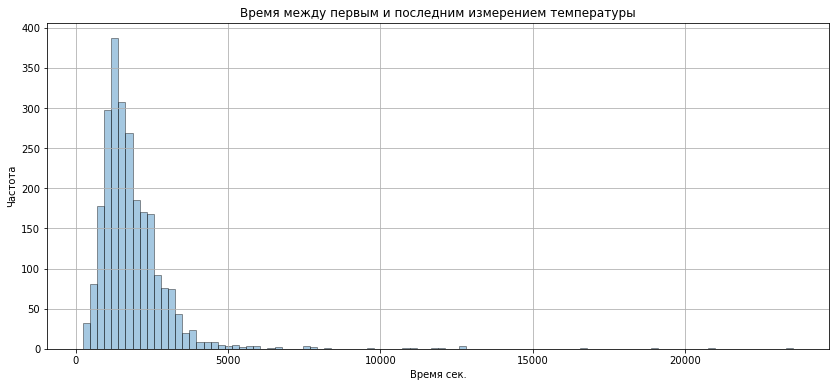

In [51]:
data_temp_by_key['начало-конец измерений'].plot.hist(bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('Время между первым и последним измерением температуры'); 
plt.ylabel('Частота')
plt.xlabel('Время сек.');

Партии с временем обработки более 2 часов вероятно выбросы.

In [52]:
print('0.5% партий с временем обработки более', data_temp_by_key['начало-конец измерений'].quantile(0.995))
print('0.5% партий с временем обработки менее', data_temp_by_key['начало-конец измерений'].quantile(0.005))

0.5% партий с временем обработки более 8033.894999999991
0.5% партий с временем обработки менее 346.485


In [53]:
long_time_list = data_temp_by_key[data_temp_by_key['начало-конец измерений']>8034].index.tolist()
fast_time_list = data_temp_by_key[data_temp_by_key['начало-конец измерений']<346].index.tolist()

In [54]:
print(long_time_list)
print(fast_time_list)

[44, 46, 118, 638, 641, 801, 1513, 1689, 1880, 1881, 1958, 2107, 2108]
[151, 600, 720, 744, 800, 812, 977, 1105, 1116, 1334, 1381, 2254, 2486]


In [55]:
# удаляем пропуски и выбросы, считаем потери
i=0

for df in [data_arc2, data_bulk2, data_bulk_time2, data_gas2, data_temp2, data_wire2, data_wire_time2]:
    df.size_0 = df['key'].unique().size
    df.query('key not in @long_time_list and key not in @fast_time_list', inplace=True)
    df.size_1 = df['key'].unique().size
    loss = df.size_0 - df.size_1
    print('из', df.size_0, 'партий', loss, '({:.1%})'.format(loss/df.size_0), 'удалили в', df_name_list[i])
    i+=1 

из 2472 партий 26 (1.1%) удалили в data_arc2
из 2404 партий 23 (1.0%) удалили в data_bulk2
из 2404 партий 23 (1.0%) удалили в data_bulk_time2
из 2492 партий 26 (1.0%) удалили в data_gas2
из 2472 партий 26 (1.1%) удалили в data_temp2
из 2369 партий 23 (1.0%) удалили в data_wire2
из 2369 партий 23 (1.0%) удалили в data_wire_time2


In [56]:
data_temp_by_key = data_temp_by_key[data_temp_by_key['начало-конец измерений'] <= 8034]
data_temp_by_key = data_temp_by_key[data_temp_by_key['начало-конец измерений'] >= 346]

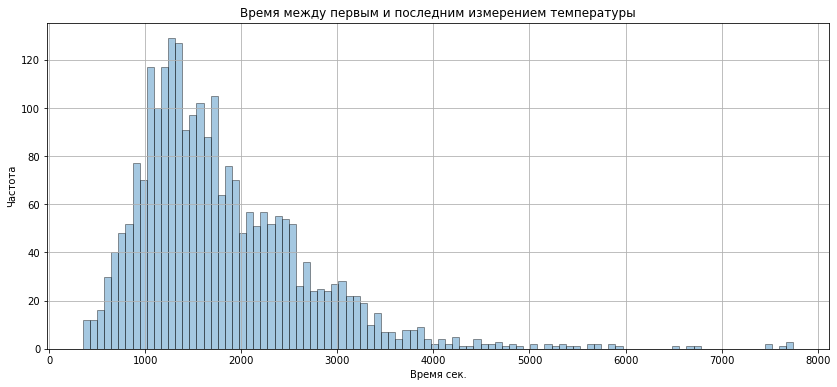

In [57]:
data_temp_by_key['начало-конец измерений'].plot.hist(bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('Время между первым и последним измерением температуры'); 
plt.ylabel('Частота')
plt.xlabel('Время сек.');

In [58]:
data_temp_by_key.describe()

,кол-во измерений,температура начальная,температура конечная,начало-конец измерений,температура предпоследняя,температура средняя
count,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,4.930090,1588.919869,1595.367948,1798.501226,1592.831153,1590.154357
std,1.710433,24.944669,15.910600,900.829610,16.378040,17.249455
min,2.000000,1519.000000,1545.000000,351.000000,1549.000000,1544.666667
25%,4.000000,1572.000000,1587.000000,1187.000000,1584.000000,1579.750000
50%,5.000000,1588.000000,1593.000000,1590.500000,1591.000000,1589.000000
75%,6.000000,1605.000000,1599.000000,2257.250000,1598.000000,1598.750000
max,14.000000,1679.000000,1700.000000,7743.000000,1705.000000,1677.250000


***
**Промежуточный вывод:**

* между 1 и последним замером температуры в партии проходит в среднем около 30 минут. 

<a name="332"></a>
#### Нагревание.

In [59]:
data_arc2['Длительность нагрева']=(
    data_arc2['Конец нагрева дугой']-data_arc2['Начало нагрева дугой']).astype('int64')/1000000000
data_arc2['Полная мощность'] = (data_arc2['Активная мощность']**2 + data_arc2['Реактивная мощность']**2)**0.5
data_arc2['АЭ*t'] = data_arc2['Активная мощность']*data_arc2['Длительность нагрева']
data_arc2['РЭ*t'] = data_arc2['Реактивная мощность']*data_arc2['Длительность нагрева']
data_arc2['Полная энергия'] = data_arc2['Полная мощность']*data_arc2['Длительность нагрева']
data_arc2['Р/А'] = data_arc2['Реактивная мощность']/data_arc2['Активная мощность']
data_arc2['Коэф_мощ'] = data_arc2['Активная мощность']/data_arc2['Полная мощность']

display(data_arc2[100:105])
#data_arc2.info()
#display(data_arc2.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность,АЭ*t,РЭ*t,Полная энергия,Р/А,Коэф_мощ
100,22,2019-05-04 04:23:37,2019-05-04 04:27:42,0.984584,0.701436,245.0,1.208892,241.223160,171.851903,296.178476,0.712419,0.814452
101,22,2019-05-04 04:31:36,2019-05-04 04:34:33,0.802886,0.538929,177.0,0.966991,142.110876,95.390409,171.157329,0.671239,0.830294
102,22,2019-05-04 04:35:27,2019-05-04 04:40:27,1.360374,0.925407,300.0,1.645295,408.112299,277.622044,493.588542,0.680259,0.826827
103,22,2019-05-04 04:41:53,2019-05-04 04:43:18,0.381265,0.243745,85.0,0.452520,32.407519,20.718333,38.464224,0.639306,0.842537
104,23,2019-05-04 05:07:02,2019-05-04 05:09:36,0.534532,0.431621,154.0,0.687038,82.317934,66.469558,105.803802,0.807474,0.778024


In [60]:
# не учтено время первого/последнего измерения температуры
data_arc_by_key = data_arc2.pivot_table(
    index='key', 
#    values=['Активная мощность', 'Реактивная мощность', 'Длительность нагрева', 'Активная энергия', 'Реактивная энергия'], 
    aggfunc={'Активная мощность': ('count', 'mean'),
             'Реактивная мощность': 'mean',
             'Длительность нагрева': 'sum', 
             'Полная мощность': 'mean',
             'АЭ*t': 'sum', 
             'РЭ*t': 'sum',
             'Полная энергия': 'sum',
             'Р/А': 'mean',
             'Коэф_мощ': 'mean',
             'Начало нагрева дугой': 'min',
             'Конец нагрева дугой': 'max'}
    )

In [61]:
data_arc_by_key.head(3)

АЭ*t Активная мощность           Длительность нагрева  \
             sum             count      mean                  sum   
key                                                                 
1    1207.804249                 5  0.975629               1098.0   
2     733.816470                 4  0.763150                811.0   
3     443.583327                 5  0.505176                655.0   

    Конец нагрева дугой  Коэф_мощ Начало нагрева дугой Полная мощность  \
                    max      mean                  min            mean   
key                                                                      
1   2019-05-03 11:28:37  0.837756  2019-05-03 11:02:14        1.165279   
2   2019-05-03 11:53:18  0.840158  2019-05-03 11:34:14        0.912304   
3   2019-05-03 12:32:19  0.845421  2019-05-03 12:06:54        0.597907   

    Полная энергия       Р/А        РЭ*t Реактивная мощность  
               sum      mean         sum                mean  
key                                                           
1      1442.377754  0.651695  787.907510            0.636648  
2       881.233565  0.645465  487.590677            0.499528  
3       525.066777  0.631751  280.936835            0.319815

In [62]:
data_arc_by_key.columns = data_arc_by_key.columns.droplevel()
data_arc_by_key.index.name = None
data_arc_by_key.set_axis(['АЭ*t_сум', 'кол-во нагревов', 'средняя мощность_а', 'длительность нагрева',
                          'время окончания', 'Коэф_мощ', 'время начала', 'средняя мощность_п', 'энергия_п', 
                          'Р/А_сред', 'РЭ*t_сум', 'средняя мощность_р'], axis='columns', inplace=True)


In [63]:
# время между началом первого нагрева и концом последнего
data_arc_by_key['начало-конец нагрева'] = (
    data_arc_by_key['время окончания'] - data_arc_by_key['время начала']).astype('int64')/1000000000
#data_arc_by_key = data_arc_by_key.drop(['время окончания', 'время начала'], axis=1)

In [64]:
data_arc_by_key = data_arc_by_key.drop(['время окончания', 'время начала'], axis=1)

In [65]:
data_arc_by_key.head(3)

,АЭ*t_сум,кол-во нагревов,средняя мощность_а,длительность нагрева,Коэф_мощ,средняя мощность_п,энергия_п,Р/А_сред,РЭ*t_сум,средняя мощность_р,начало-конец нагрева
1,1207.804249,5,0.975629,1098.0,0.837756,1.165279,1442.377754,0.651695,787.907510,0.636648,1583.0
2,733.816470,4,0.763150,811.0,0.840158,0.912304,881.233565,0.645465,487.590677,0.499528,1144.0
3,443.583327,5,0.505176,655.0,0.845421,0.597907,525.066777,0.631751,280.936835,0.319815,1525.0


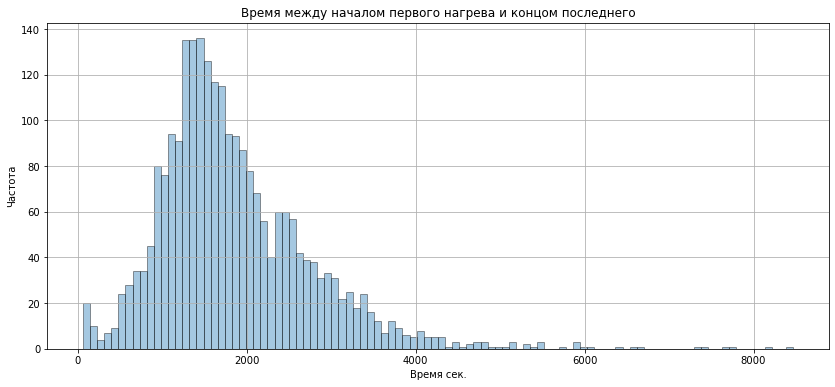

In [66]:
data_arc_by_key['начало-конец нагрева'].plot.hist(bins=100, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('Время между началом первого нагрева и концом последнего'); 
plt.ylabel('Частота')
plt.xlabel('Время сек.');

In [67]:
data_arc_by_key.describe()

,АЭ*t_сум,кол-во нагревов,средняя мощность_а,длительность нагрева,Коэф_мощ,средняя мощность_п,энергия_п,Р/А_сред,РЭ*t_сум,средняя мощность_р,начало-конец нагрева
count,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,713.632722,4.603434,0.674399,794.775961,0.801447,0.842887,893.116371,0.747663,533.741026,0.502642,1860.628373
std,488.160408,1.529710,0.204298,321.147212,0.031912,0.250622,607.735386,0.088809,364.342396,0.151196,927.888506
min,12.193819,1.000000,0.187837,61.000000,0.552784,0.228541,16.488778,0.568125,10.127814,0.130062,61.000000
25%,366.356107,4.000000,0.526212,573.000000,0.790117,0.660460,461.408080,0.696850,274.509911,0.392797,1268.000000
50%,609.820525,4.000000,0.651029,772.000000,0.806849,0.819562,767.279131,0.732328,457.555171,0.490537,1674.000000
75%,931.138540,6.000000,0.801282,983.750000,0.820457,0.997856,1165.587740,0.776129,694.357291,0.598134,2328.250000
max,4114.814680,13.000000,1.819169,2658.000000,0.869155,2.147979,5123.890430,1.552491,3045.174869,1.141721,8467.000000


***
**Промежуточный вывод:**

* за партию между началом первого нагрева и окончанием последнего проходит около 30 минут. 

<a name="333"></a>
#### Добавление сыпучих и проволочных материалов.

In [68]:
# суммарный объем сыпучих матриалов
data_bulk2['Bulk_sum'] = data_bulk2[bulk_col_list].sum(axis=1)

In [69]:
# суммарный объем проволочных матриалов
data_wire2['Wire_sum'] = data_wire2[wire_col_list].sum(axis=1)

In [70]:
data_arc_by_key

,АЭ*t_сум,кол-во нагревов,средняя мощность_а,длительность нагрева,Коэф_мощ,средняя мощность_п,энергия_п,Р/А_сред,РЭ*t_сум,средняя мощность_р,начало-конец нагрева
1,1207.804249,5,0.975629,1098.0,0.837756,1.165279,1442.377754,0.651695,787.907510,0.636648,1583.0
2,733.816470,4,0.763150,811.0,0.840158,0.912304,881.233565,0.645465,487.590677,0.499528,1144.0
3,443.583327,5,0.505176,655.0,0.845421,0.597907,525.066777,0.631751,280.936835,0.319815,1525.0
4,670.663327,4,0.802313,741.0,0.841682,0.953741,796.911309,0.641443,429.935932,0.515074,1093.0
5,997.496095,4,0.836793,869.0,0.828104,1.008939,1199.137958,0.676904,664.940090,0.563161,1362.0
...,...,...,...,...,...,...,...,...,...,...,...
2495,626.167357,4,0.802673,723.0,0.807313,0.996717,778.818234,0.731065,462.572488,0.590194,1208.0
2496,727.868032,6,0.700511,940.0,0.829826,0.842839,875.261419,0.672407,485.842067,0.468364,1406.0
2497,427.535518,3,0.737460,569.0,0.765895,0.961672,556.930349,0.839576,356.837023,0.617090,764.0
2498,629.928649,5,0.681745,750.0,0.826522,0.828750,767.817794,0.681031,438.905595,0.471086,1358.0


<a name="334"></a>
#### Вывод по созданным признакам.

На основании имеющихся данных сформированы следующие признаки:

* data_arc_by_key - АЭ*t_сум (сумма произведений активной энергии на время), количество нагревов, активная мощность (средняя), длительность нагрева (суммарная), коэффициент мощности, полная мощность (средняя), энергия полная, Р/А_сред (отношение реактивной энергии к активной), РЭ*t_сум (сумма произведений реактивной энергии на время), реактивная мощность  (средняя), энергия реактивной мощности, суммарная длительность циклов нагрев/охлаждение


* data_temp_by_key - кол-во измерений (температуры), температура начальная, температура конечная, начало-конец измерений, температура предпоследняя, температура средняя (не включая последнюю).


* data_bulk2 - суммарный объем сыпучих матриалов


* data_wire2 - суммарный объем проволочных матриалов

Вероятно многие будут мултиколлинеарны.

<a name="4"></a>
## Исследовательский анализ данных.

<a name="41"></a>
### Температура.

<a name="411"></a>
#### Начальные данные

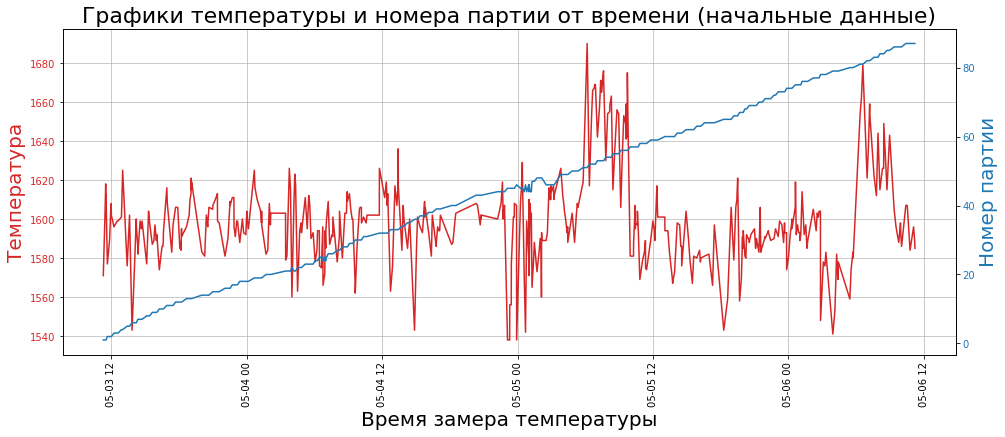

In [71]:
data_temp3 = data_temp.copy()
data_temp3['Время замера'] = data_temp3['Время замера'].astype('datetime64')
data_temp3.index = data_temp3['Время замера']
data_temp3.sort_index(inplace=True)

x = data_temp3[0:500]['Время замера']
y1 = data_temp3[0:500]['Температура']
y2 = data_temp3[0:500]['key']

# температура
fig, ax1 = plt.subplots(1,1,figsize=(16,6)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Время замера температуры', fontsize=20)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Температура', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# номер партии
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel("Номер партии", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Графики температуры и номера партии от времени (начальные данные)", fontsize=22)
plt.show();

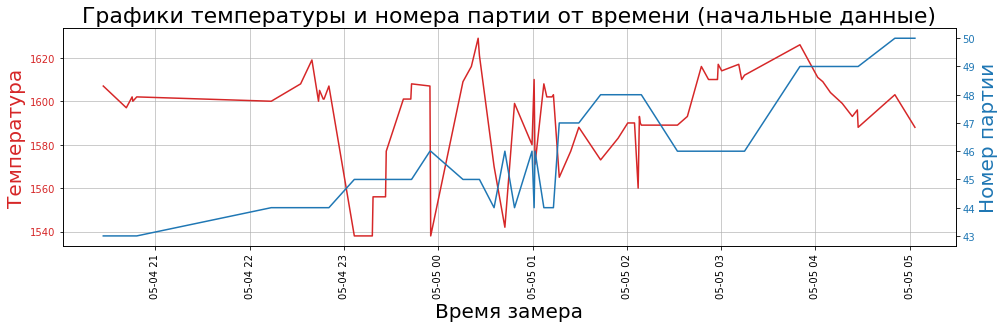

In [72]:
x = data_temp3[220:290]['Время замера']
y1 = data_temp3[220:290]['Температура']
y2 = data_temp3[220:290]['key']

# температура
fig, ax1 = plt.subplots(1,1,figsize=(16,4)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Время замера', fontsize=20)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Температура', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# номер партии
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel("Номер партии", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Графики температуры и номера партии от времени (начальные данные)", fontsize=22)
plt.show();

<a name="412"></a>
#### Измененные данные

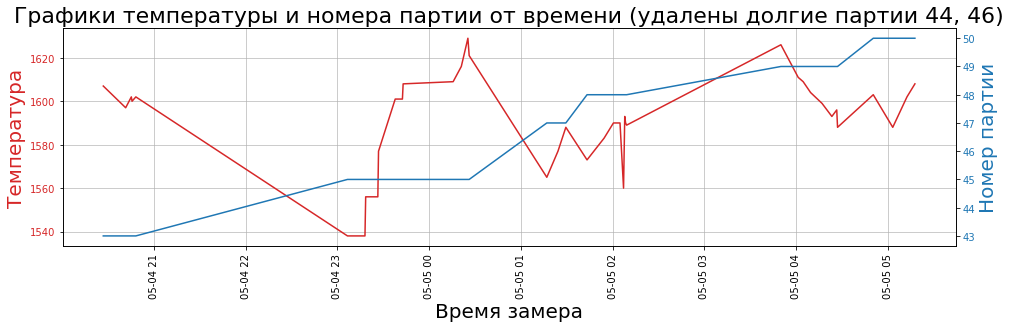

In [73]:
data_temp4 = data_temp2.copy()
data_temp4['Время замера'] = data_temp4['Время замера'].astype('datetime64')
data_temp4.index = data_temp4['Время замера']
data_temp4.sort_index(inplace=True)


x = data_temp4[220:260]['Время замера']
y1 = data_temp4[220:260]['Температура']
y2 = data_temp4[220:260]['key']

# температура
fig, ax1 = plt.subplots(1,1,figsize=(16,4)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Время замера', fontsize=20)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Температура', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# номер партии
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel("Номер партии", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Графики температуры и номера партии от времени (удалены долгие партии 44, 46)", fontsize=22)
plt.show();

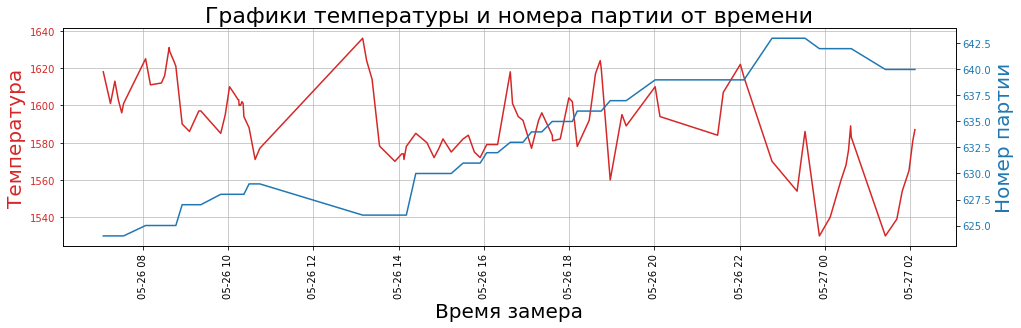

In [74]:
x = data_temp4[3120:3220]['Время замера']
y1 = data_temp4[3120:3220]['Температура']
y2 = data_temp4[3120:3220]['key']

# температура
fig, ax1 = plt.subplots(1,1,figsize=(16,4)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Время замера', fontsize=20)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Температура', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# номер партии
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel("Номер партии", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Графики температуры и номера партии от времени", fontsize=22)
plt.show();

In [75]:
#data_temp4[3125:3175]

***
**Промежуточный вывод:**

* в данных data_temp есть непоследовательные измерения температуры разных партий. Часть не попадут в конечный набор данных из-за большого времени обработки (удалены по 0,5% самых долгих и самых быстрых партий). Возможно связано с одновременным изготовлением нескольких партий (разные ковши?) Или непоследовательном (в некоторых случаях) присвоением партии номера. Посмотрим на поведение моделей.

In [76]:
data_temp_by_key['кол-во измерений'].nunique()

13

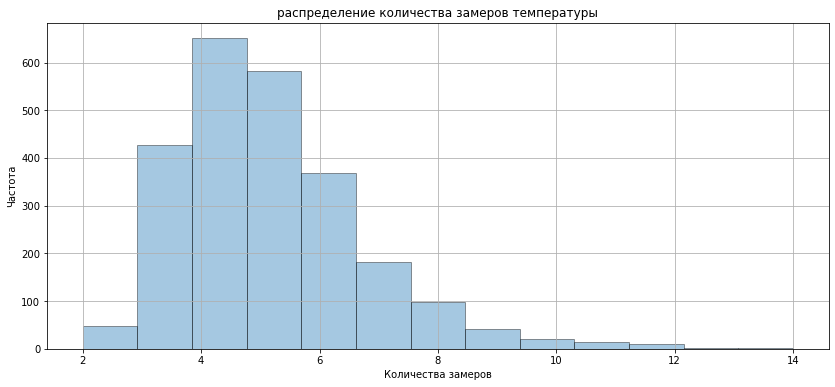

In [77]:
data_temp_by_key['кол-во измерений'].plot.hist(bins=13, edgecolor = 'black', figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение количества замеров температуры') 
plt.ylabel('Частота')
plt.xlabel('Количества замеров');

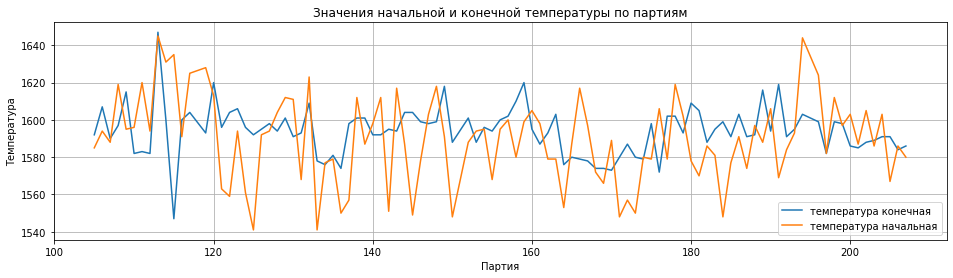

In [78]:
data_temp_by_key[100:200].plot(y=['температура конечная', 'температура начальная'], figsize=(16, 4), grid=True)
plt.title("Значения начальной и конечной температуры по партиям")
plt.xlabel("Партия")
plt.ylabel("Температура")
plt.show();

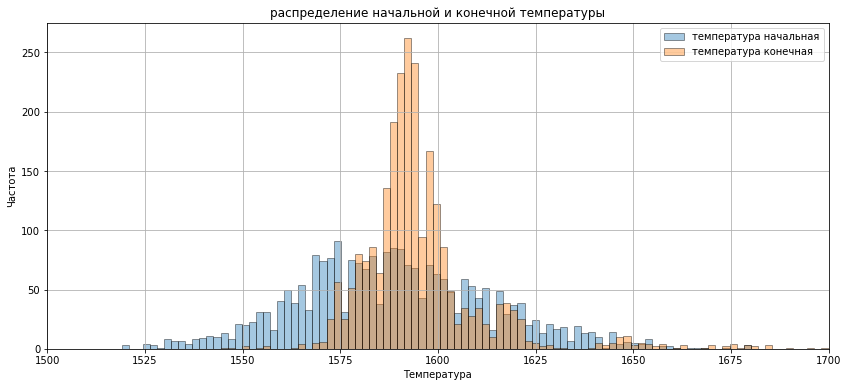

In [79]:
data_temp_by_key[['температура начальная', 'температура конечная']].plot.hist(bins=100, edgecolor = 'black', 
                                                                              figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение начальной и конечной температуры') 
plt.ylabel('Частота')
plt.xlabel('Температура')
plt.xlim([1500, 1700]);

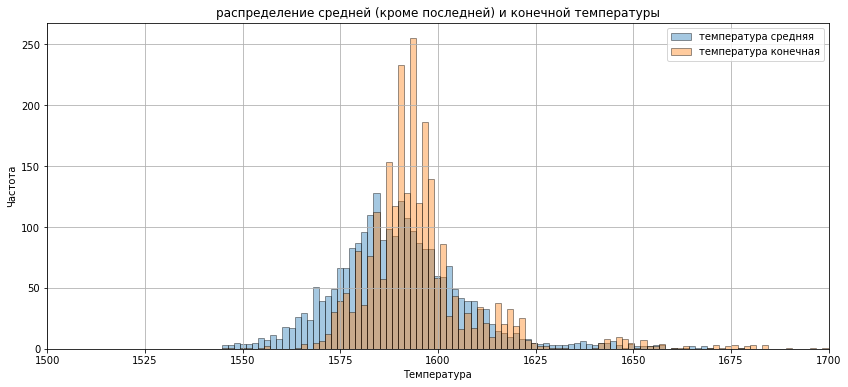

In [80]:
data_temp_by_key[['температура средняя', 'температура конечная']].plot.hist(bins=100, edgecolor = 'black', 
                                                                            figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение средней (кроме последней) и конечной температуры') 
plt.ylabel('Частота')
plt.xlabel('Температура')
plt.xlim([1500, 1700]);

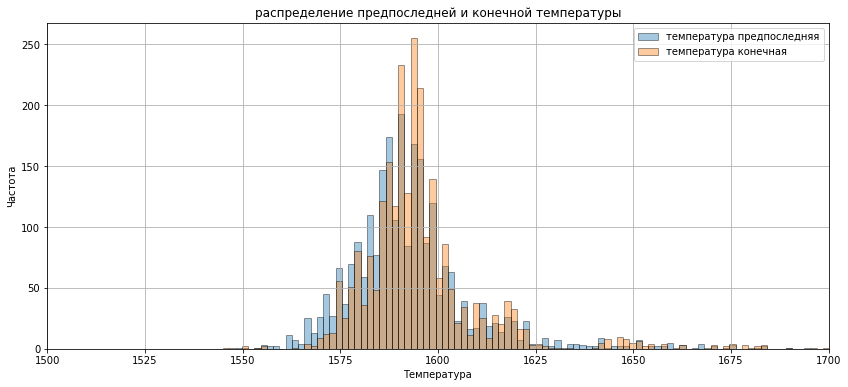

In [81]:
data_temp_by_key[['температура предпоследняя', 'температура конечная']].plot.hist(bins=100, edgecolor = 'black',
                                                                                  figsize=(14, 6), grid=True, alpha = 0.4)
plt.title('распределение предпоследней и конечной температуры') 
plt.ylabel('Частота')
plt.xlabel('Температура')
plt.xlim([1500, 1700]);

In [82]:
data_temp_by_key.describe()

,кол-во измерений,температура начальная,температура конечная,начало-конец измерений,температура предпоследняя,температура средняя
count,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,4.930090,1588.919869,1595.367948,1798.501226,1592.831153,1590.154357
std,1.710433,24.944669,15.910600,900.829610,16.378040,17.249455
min,2.000000,1519.000000,1545.000000,351.000000,1549.000000,1544.666667
25%,4.000000,1572.000000,1587.000000,1187.000000,1584.000000,1579.750000
50%,5.000000,1588.000000,1593.000000,1590.500000,1591.000000,1589.000000
75%,6.000000,1605.000000,1599.000000,2257.250000,1598.000000,1598.750000
max,14.000000,1679.000000,1700.000000,7743.000000,1705.000000,1677.250000


***
**Промежуточный вывод:**

Температура в конце обработки в среднем на 5 градусов выше начальной температуры, но простой зависимости нет. Конечная температура разбросана меньше.

Наиболее близкое к распределению конечной температуры распределение предпоследней температуры.

<a name="42"></a>
### Нагревание.

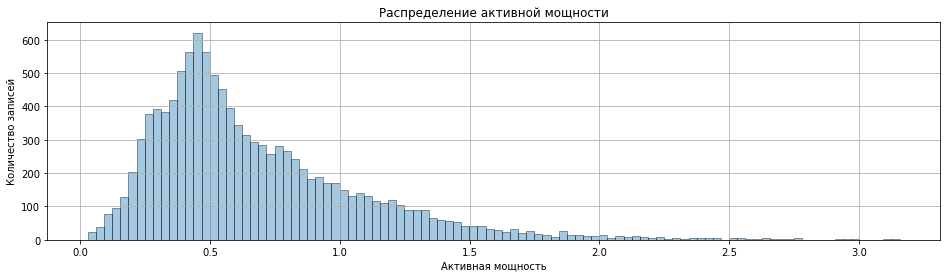

In [83]:
data_arc2['Активная мощность'].plot.hist(bins=100, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение активной мощности'); 
plt.ylabel('Количество записей')
plt.xlabel('Активная мощность');

Нормальное распределение с правым хвостом, оснований считать высокие значения выбросами нет.

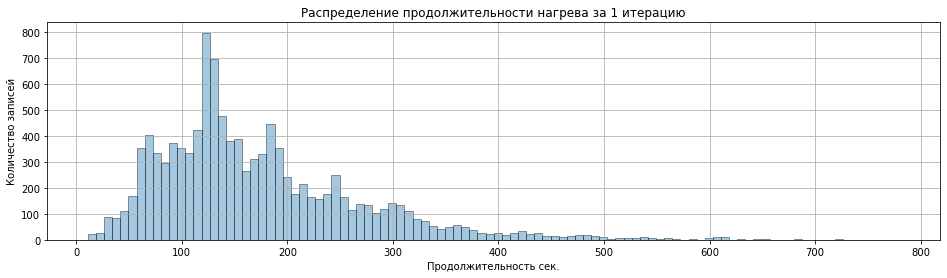

In [84]:
data_arc2['Длительность нагрева'].plot.hist(bins=100, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение продолжительности нагрева за 1 итерацию'); 
plt.ylabel('Количество записей')
plt.xlabel('Продолжительность сек.');

Близко к нормальному с правым хвостом. Пики в районе 60, 120, 180 ... сек (1, 2 , 3 ... мин.). Оснований считать высокие значения выбросами нет.

In [85]:
data_arc_by_key.head(3)

,АЭ*t_сум,кол-во нагревов,средняя мощность_а,длительность нагрева,Коэф_мощ,средняя мощность_п,энергия_п,Р/А_сред,РЭ*t_сум,средняя мощность_р,начало-конец нагрева
1,1207.804249,5,0.975629,1098.0,0.837756,1.165279,1442.377754,0.651695,787.907510,0.636648,1583.0
2,733.816470,4,0.763150,811.0,0.840158,0.912304,881.233565,0.645465,487.590677,0.499528,1144.0
3,443.583327,5,0.505176,655.0,0.845421,0.597907,525.066777,0.631751,280.936835,0.319815,1525.0


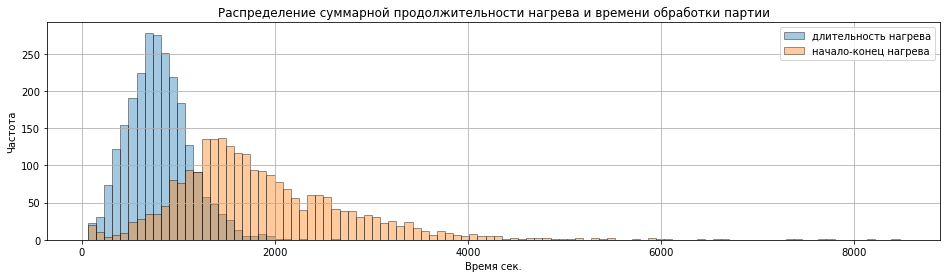

In [86]:
data_arc_by_key[['длительность нагрева', 'начало-конец нагрева']].plot.hist(bins=100, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение суммарной продолжительности нагрева и времени обработки партии'); 
plt.ylabel('Частота')
plt.xlabel('Время сек.');

In [87]:
#data_arc_by_key[['энергия_п', 'энергия_а', 'энергия_р']].plot.hist(bins=100, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
#plt.title('Распределение энергии по партиям'); 
#plt.ylabel('Частота')
#plt.xlabel('Энергия');

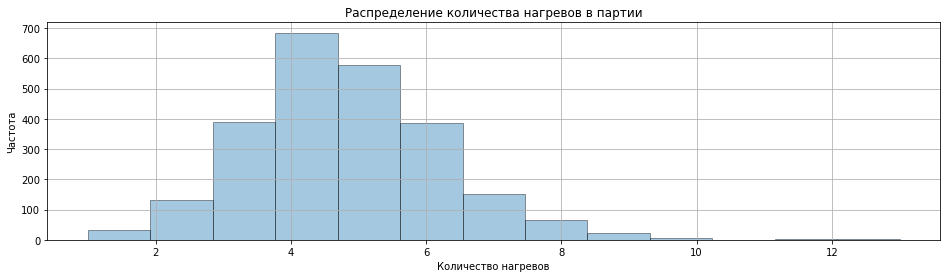

In [88]:
data_arc_by_key['кол-во нагревов'].plot.hist(bins=13, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение количества нагревов в партии'); 
plt.ylabel('Частота')
plt.xlabel('Количество нагревов');

<a name="43"></a>
### Добавление сыпучих и проволочных материалов, продувка.

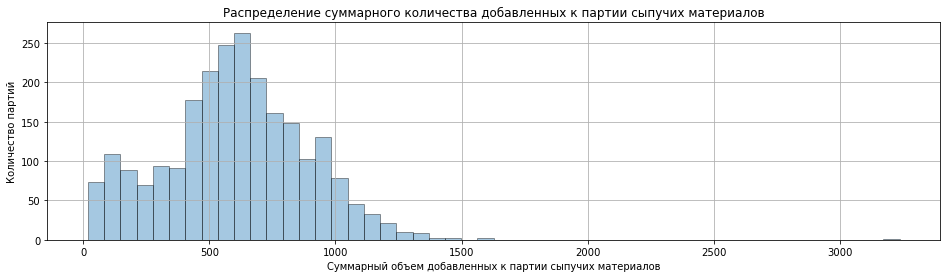

In [89]:
data_bulk2['Bulk_sum'].plot.hist(bins=50, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение суммарного количества добавленных к партии сыпучих материалов'); 
plt.ylabel('Количество партий')
plt.xlabel('Суммарный объем добавленных к партии сыпучих материалов');

In [90]:
display(data_bulk2[data_bulk2['Bulk_sum']>1600])
display(data_bulk2[data_bulk2['Bulk 12']>900])
#display(data_arc2[data_arc2['key']==303])
#display(data_temp2[data_temp2['key']==303])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_sum
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0,3235.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk_sum
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0,3235.0


Близко к нормальному с правым хвостом. Выделяется центральный пик, а также 2 малых - вероятно связано с изготовлением различных марок стали.

***
**Промежуточный вывод:**

*  Подозрительно высокое значение подачи сыпучих материалов (Bulk 12 и Bulk_sum) в партии 303. Вероятно необходимо удалить.

In [91]:
# удаляем 303 партию
for df in [data_arc2, data_bulk2, data_bulk_time2, data_gas2, data_temp2, data_wire2, data_wire_time2]:
    df.query('key != 303', inplace=True)

data_temp_by_key = data_temp_by_key[data_temp_by_key.index != 303]
data_arc_by_key = data_arc_by_key[data_arc_by_key.index != 303]

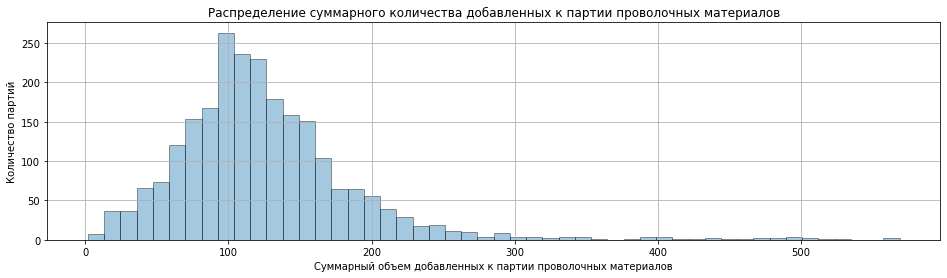

In [92]:
data_wire2['Wire_sum'].plot.hist(bins=50, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение суммарного количества добавленных к партии проволочных материалов'); 
plt.ylabel('Количество партий')
plt.xlabel('Суммарный объем добавленных к партии проволочных материалов');

Нормальное распределение с правым хвостом. Оснований считать высокие значения выбросами нет.

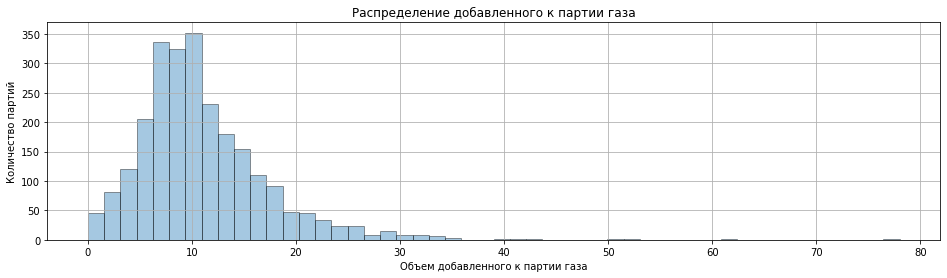

In [93]:
data_gas2['Газ 1'].plot.hist(bins=50, edgecolor = 'black', figsize=(16, 4), grid=True, alpha = 0.4)
plt.title('Распределение добавленного к партии газа'); 
plt.ylabel('Количество партий')
plt.xlabel('Объем добавленного к партии газа');

Нормальное распределение с правым хвостом. Оснований считать высокие значения выбросами нет.

***
**Вывод:**

* в данных о температуре есть непоследовательные измерения температуры разных партий. Возможно связано с одновременным изготовлением нескольких партий (разные ковши?) Или непоследовательном (в некоторых случаях) присвоением партии номера. Возможно стоит удалить все такие партии (включая соседей).

* В признаках встречаются "экстремальные" значения. При низких значениях MAE стоит внимательнее учесть выбросы.


<a name="5"></a>
## Подготовка к обучению.

<a name="51"></a>
### Объединение таблиц.

In [94]:
for df in [data_bulk2, data_gas2, data_wire2]:
    df.set_index('key', inplace=True)
    df.index.name = None

In [95]:
len(data_temp_by_key.index)

2445

In [96]:
# данные о температуре и нагреве соединяем 'inner'
data = data_temp_by_key.join(data_arc_by_key, how='inner')
print(len(data.index))

2445


In [97]:
# все остальные 'left'
data = data.join(data_gas2, how='left').join(data_bulk2, how='left').join(data_wire2, how='left')

In [98]:
#data[data['Газ 1'] != data['Газ 1']].T

***
**Промежуточный вывод:**

* Для строк с пропусками в данных о подаче газа (всего 2) остальные значения есть - можно заполнить нулями.
* Судя по распределению суммарного количества добавленных к партии сыпучих материалов, нулевые и околонулевые значения это нормально - заменяю нулями
* Ноль для проволочных материалов - необычно - удаляю.

In [99]:
data.dropna(subset = ['Wire_sum'], inplace = True)
data.fillna(0, inplace=True)
print(len(data.index))
data.describe().T

2345


,count,mean,std,min,25%,50%,75%,max
кол-во измерений,2345.0,4.943284,1.697652,2.000000,4.000000,5.000000,6.000000,14.000000
температура начальная,2345.0,1587.445203,23.630305,1519.000000,1571.000000,1587.000000,1603.000000,1673.000000
температура конечная,2345.0,1593.358635,11.062100,1545.000000,1587.000000,1593.000000,1598.000000,1653.000000
начало-конец измерений,2345.0,1825.779531,903.652641,351.000000,1209.000000,1624.000000,2273.000000,7743.000000
температура предпоследняя,2345.0,1590.976972,12.422606,1549.000000,1583.000000,1590.000000,1597.000000,1662.000000
температура средняя,2345.0,1588.442897,14.330114,1544.666667,1579.250000,1588.333333,1597.600000,1643.666667
АЭ*t_сум,2345.0,702.598513,481.014455,12.193819,359.253272,599.744670,920.079788,4114.814680
кол-во нагревов,2345.0,4.641791,1.534460,1.000000,4.000000,5.000000,6.000000,13.000000
средняя мощность_а,2345.0,0.665100,0.196850,0.187837,0.521743,0.640063,0.788747,1.421416
длительность нагрева,2345.0,794.490832,322.809909,61.000000,572.000000,770.000000,983.000000,2658.000000


In [100]:
#data[data.isnull().any(1)]

***
**Промежуточный вывод:**

* В конечной таблице 2345 партий из 3081-3239 партий в начальных таблицах. Потери составили 23,9-27,6% партий.

<a name="52"></a>
### Выявление корреляции.

In [101]:
def get_red_pair(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_largest_correlations(df, n=30):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_red_pair(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr = get_largest_correlations(data)
print(corr)

Коэф_мощ                   Р/А_сред                     0.997151
АЭ*t_сум                   энергия_п                    0.996606
энергия_п                  РЭ*t_сум                     0.991827
Bulk 9                     Wire 8                       0.990009
средняя мощность_а         средняя мощность_п           0.988475
АЭ*t_сум                   РЭ*t_сум                     0.978096
средняя мощность_п         средняя мощность_р           0.970620
начало-конец измерений     начало-конец нагрева         0.930875
средняя мощность_а         средняя мощность_р           0.923393
длительность нагрева       энергия_п                    0.895144
                           РЭ*t_сум                     0.891617
АЭ*t_сум                   длительность нагрева         0.889518
Bulk 12                    Bulk_sum                     0.872176
температура начальная      температура средняя          0.863434
температура конечная       температура предпоследняя    0.850380
кол-во нагревов          

In [102]:
data.corr()['температура конечная'].sort_values(ascending=False)

температура конечная         1.000000
температура предпоследняя    0.850380
температура средняя          0.611316
Wire 1                       0.318135
температура начальная        0.314280
АЭ*t_сум                     0.305639
длительность нагрева         0.301283
энергия_п                    0.296324
РЭ*t_сум                     0.278202
Bulk 12                      0.265775
Bulk 15                      0.264362
Bulk_sum                     0.229944
начало-конец нагрева         0.214186
средняя мощность_а           0.210872
кол-во нагревов              0.204616
начало-конец измерений       0.198681
Bulk 4                       0.197153
средняя мощность_п           0.190873
Коэф_мощ                     0.160465
средняя мощность_р           0.149972
кол-во измерений             0.120985
Bulk 14                      0.106819
Газ 1                        0.082951
Wire_sum                     0.074016
Bulk 10                      0.062042
Wire 8                      -0.002298
Bulk 9      

***
**Комментарий:**

Из пар мультиколлинеарных признаков при формировании features необходимо удалить наименее коррелирующие с целевым:  
    
*  'Р/А_сред', 'энергия_п', 'РЭ*t_сум', 'средняя мощность_п', 'средняя мощность_р', Bulk 9', 'Bulk_sum'

In [103]:
#data_col_list = data.columns.tolist()

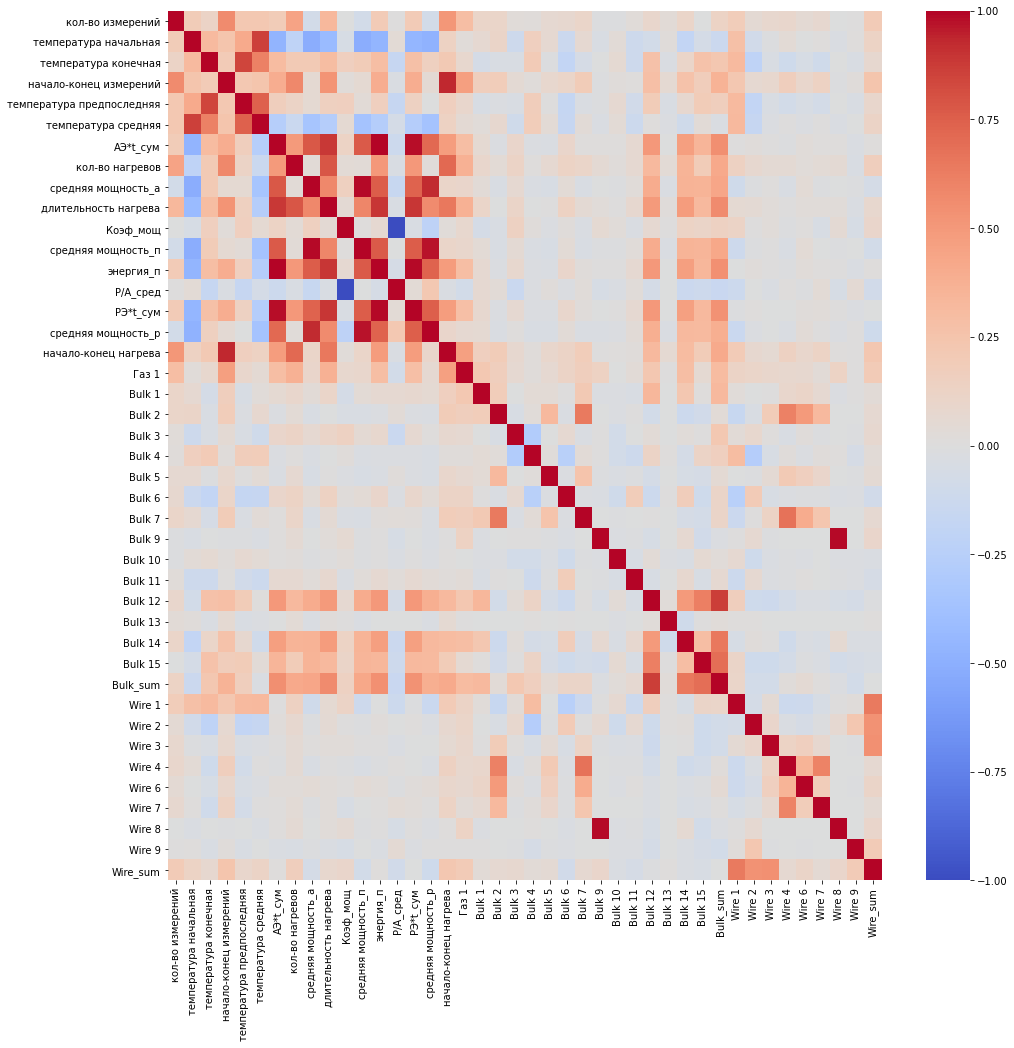

In [104]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(data.corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

***
**Вывод:**

* Для некоторых созданных признаков значения корреляции почти 1.

* Конечная температура очень хорошо коррелирует с предпоследней 

<a name="6"></a>
## Обучение и проверка моделей.

<a name="61"></a>
### Подготовка к обучению

In [105]:
#data.columns.tolist()

In [106]:
new_col_axis = ['temp_count',
 'temp_first',
 'temp_last',
 'temp_time_dif',
 'temp_second_to_last',
 'temp_mean',
 'ActiveE*t_sum',
 'heat_count',
 'heat_pow_active',
 'heat_up_time',
 'heat_pow_ratio',
 'heat_pow_full_mean',
 'heat_E_full',
 'react_act_ratio_mean',
 'ReactE*t_sum',
 'heat_pow_react_mean',
 'heat_time_full',
 'gas_1',
 'Bulk_1',
 'Bulk_2',
 'Bulk_3',
 'Bulk_4',
 'Bulk_5',
 'Bulk_6',
 'Bulk_7',
 'Bulk_9',
 'Bulk_10',
 'Bulk_11',
 'Bulk_12',
 'Bulk_13',
 'Bulk_14',
 'Bulk_15',
 'Bulk_sum',
 'Wire_1',
 'Wire_2',
 'Wire_3',
 'Wire_4',
 'Wire_6',
 'Wire_7',
 'Wire_8',
 'Wire_9',
 'Wire_sum']

In [107]:
# мультиколлинеарные признаки
# 'react_act_ratio_mean', 'heat_E_full', 'ReactE*t_sum', 'heat_pow_full_mean', 'heat_pow_react_mean', 'Bulk_9', 'Bulk_sum'

In [108]:
data.set_axis(new_col_axis, axis='columns', inplace=True)

In [109]:
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

In [110]:
data.loc[data.loc[:, 'temp_count'] > 12] = 12
#data['кол-во измерений'].value_counts()

In [111]:
# Поменяем значения 2 редких значения 'кол-во измерений' (13 и 14) на 12 чтобы иметь возможность stratify=data['temp_count']
#data.loc[data.loc[:, 'temp_count'] > 12] = 12
#data['temp_count'].value_counts()

In [112]:
# списки признаков

# полный
feat_full = data.columns.tolist()
feat_full.remove('temp_last')

# только первое измерение температуры
feat_first_temp = feat_full.copy()
for col in ['temp_second_to_last', 'temp_mean', 'temp_count']:
    feat_first_temp.remove(col)

# дополнительно исключены зависимые признаки
feat_first_temp_drop = feat_first_temp.copy()
for col in ['react_act_ratio_mean', 'heat_E_full', 'ReactE*t_sum', 'heat_pow_full_mean', 
            'heat_pow_react_mean', 'Bulk_9', 'Bulk_sum']:
    feat_first_temp_drop.remove(col)

# количество признаков дополнительно уменьшено до 20 наиболее значимых
feat_20 = feat_first_temp_drop.copy()
for col in ['Bulk_1', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_14', 
            'Bulk_15', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_8', 'gas_1']:
    feat_20.remove(col)

# полностью отсутствуют данные об измерении температуры
feat_no_temp = data.columns.tolist()
for col in ['temp_last', 'temp_first', 'temp_second_to_last', 'temp_mean', 'temp_time_dif', 'temp_count']:
    feat_no_temp.remove(col)

# список наборов признаков
feat_list = [feat_full, feat_first_temp, feat_first_temp_drop, feat_20, feat_no_temp]
feat_name_list = ['feat_full', 'feat_first_temp', 'feat_first_temp_drop', 'feat_20', 'feat_no_temp']

target = ['temp_last']

In [113]:
# разбиваем на train/test
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

***
**Комментарий:**

Создано 5 наборов признаков:

* feat_full - включает в себя данные о промежуточных измерениях температуры в партии

* feat_first_temp - включает в себя значение 1 измерения температуры и время между 1 и последним измерениями

* feat_first_temp_drop - дополнительно исключены зависимые признаки

* feat_20 - количество признаков дополнительно уменьшено до 20 наиболее значимых (меняется в зависимости от модели)

* feat_no_temp - полностью без данных о температуре

<a name="62"></a>
### LinearRegression

In [114]:
scaler = StandardScaler() #масштабируем признаки

model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    
    # нормализация
    scaler.fit(data_train[feat])
    features_train = data_train[feat].copy()
    features_train = scaler.transform(features_train)
    features_test = data_test[feat].copy()
    features_test = scaler.transform(features_test)
    
    model = LinearRegression()
    b={}
    b['model_name'] = 'LinearRegression'
    b['feat_name'] = feat_name_list[i]
    b['model_valid_mae'] = -cross_val_score(model, features_train, data_train[target], 
                                            cv=kfold, scoring='neg_mean_absolute_error').mean()
    
    beg_time = datetime.datetime.now()
    model.fit(features_train, data_train[target])
    b['model_fit_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    beg_time = datetime.datetime.now()
    model_predicted = model.predict(features_test)
    b['model_pred_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    b['model_test_mae'] = mean_absolute_error(data_test[target], model_predicted)
    model_dict[i] = b

    if feat == feat_first_temp_drop:
        mod_coef = abs(model.coef_.ravel())
        # индексированные названием признака веса (на np.std можно не домножать т.к. после нормализации значения = 1)
        rcoef = pd.Series(np.std(features_train, 0)*mod_coef/mod_coef.sum(), index=feat)
        
        # Меняем список из 20 наиболее значимых
        feat_20 = rcoef.nlargest(20).index.tolist()
        
    print('test MAE:%.1f' %b['model_test_mae'], 'valid MAE:%.1f' %b['model_valid_mae'], b['model_name'], b['feat_name'])
    i+=1

test MAE:3.5 valid MAE:3.6 LinearRegression feat_full
test MAE:5.6 valid MAE:5.8 LinearRegression feat_first_temp
test MAE:5.5 valid MAE:5.9 LinearRegression feat_first_temp_drop
test MAE:6.5 valid MAE:6.6 LinearRegression feat_20
test MAE:7.3 valid MAE:7.4 LinearRegression feat_no_temp


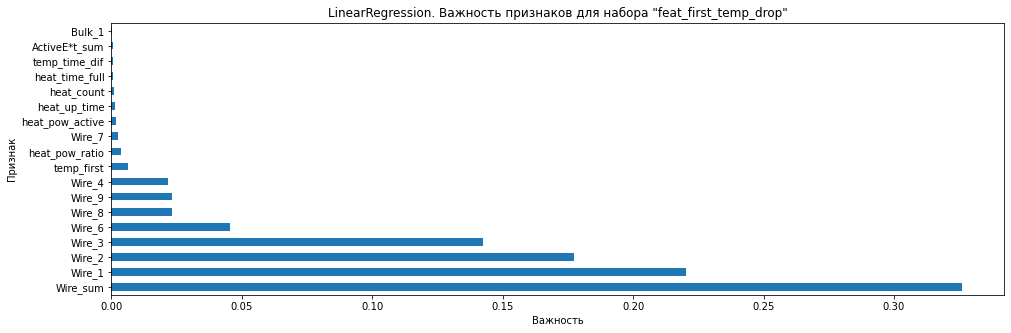

In [115]:
rcoef.nlargest(18).plot(kind='barh', figsize=(16, 5))
plt.title('LinearRegression. Важность признаков для набора "feat_first_temp_drop"')
plt.ylabel('Признак')
plt.xlabel('Важность');

In [116]:
final_table = pd.DataFrame(model_dict).T
final_table

,model_name,feat_name,model_valid_mae,model_fit_time,model_pred_time,model_test_mae
0,LinearRegression,feat_full,3.56257,0.079,0.032,3.54115
1,LinearRegression,feat_first_temp,5.84873,0.073,0.008,5.56577
2,LinearRegression,feat_first_temp_drop,5.8677,0.119,0.002,5.52818
3,LinearRegression,feat_20,6.61946,0.094,0.015,6.47699
4,LinearRegression,feat_no_temp,7.35617,0.01,0,7.27071


<a name="63"></a>
### DecisionTreeRegressor

In [117]:
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    model = DecisionTreeRegressor()
    beg_time = datetime.datetime.now()
    b={}
    b['model_name'] = 'DecisionTreeRegressor'
    b['feat_name'] = feat_name_list[i]
    
    parametrs = { 'max_depth': [4, 5, 7, 8],
                  'min_samples_leaf': [2, 4],
                  'min_samples_split': [4, 14, 20, 30]}
    
    grid = GridSearchCV(model, parametrs, cv=kfold, scoring='neg_mean_absolute_error', iid=True)
    grid.fit(data_train[feat], data_train[target])
    b['params'] = grid.best_params_
    model = DecisionTreeRegressor().set_params(**b['params'])
    b['model_valid_mae'] = -cross_val_score(model, data_train[feat], data_train[target], 
                                            cv=kfold, scoring='neg_mean_absolute_error').mean()
    
    beg_time = datetime.datetime.now()
    model.fit(data_train[feat], data_train[target])
    b['model_fit_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    beg_time = datetime.datetime.now()
    model_predicted = model.predict(data_test[feat])
    b['model_pred_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    b['model_test_mae'] = mean_absolute_error(data_test[target], model_predicted)
    model_dict[i] = b

    # сохраним важность признаков 
    if feat == feat_first_temp:
        tree_feat_importances = pd.Series(model.feature_importances_, index=feat_first_temp)

        # Меняем список из 20 наиболее значимых
        feat_20 = rcoef.nlargest(20).index.tolist()
    
    print('test MAE:%.1f' %b['model_test_mae'], 'valid MAE:%.1f' %b['model_valid_mae'], b['model_name'], b['feat_name'])
    print(b['params'])
    i+=1

C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:4.3 valid MAE:5.0 DecisionTreeRegressor feat_full
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 30}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:7.0 valid MAE:8.4 DecisionTreeRegressor feat_first_temp
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 20}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:6.9 valid MAE:7.5 DecisionTreeRegressor feat_first_temp_drop
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 20}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:7.2 valid MAE:7.6 DecisionTreeRegressor feat_20
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 20}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:8.0 valid MAE:8.0 DecisionTreeRegressor feat_no_temp
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 14}


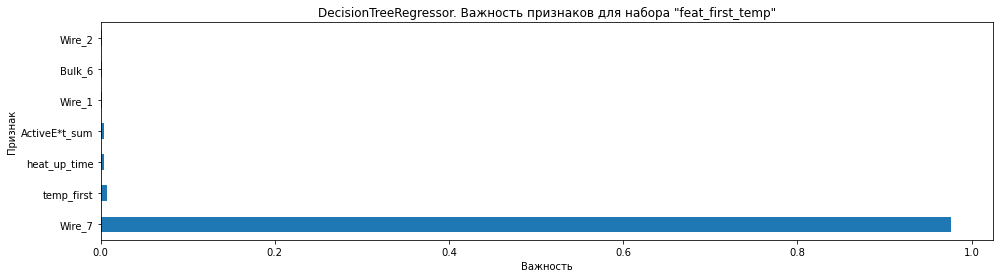

In [118]:
tree_feat_importances.nlargest(7).plot(kind='barh', figsize=(16, 4))
plt.title('DecisionTreeRegressor. Важность признаков для набора "feat_first_temp"')
plt.ylabel('Признак')
plt.xlabel('Важность');

In [119]:
display(pd.DataFrame(model_dict).T)
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)

,model_name,feat_name,params,model_valid_mae,model_fit_time,model_pred_time,model_test_mae
0,DecisionTreeRegressor,feat_full,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",5.00028,0.04,0.01,4.33042
1,DecisionTreeRegressor,feat_first_temp,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",8.41438,0.038,0.002,6.97661
2,DecisionTreeRegressor,feat_first_temp_drop,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",7.50945,0.04,0.01,6.90871
3,DecisionTreeRegressor,feat_20,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",7.60649,0.03,0.008,7.17618
4,DecisionTreeRegressor,feat_no_temp,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",7.99213,0.028,0.002,7.96283


In [120]:
final_table

,model_name,feat_name,model_valid_mae,model_fit_time,model_pred_time,model_test_mae,params
0,LinearRegression,feat_full,3.56257,0.079,0.032,3.54115,NaN
1,LinearRegression,feat_first_temp,5.84873,0.073,0.008,5.56577,NaN
2,LinearRegression,feat_first_temp_drop,5.8677,0.119,0.002,5.52818,NaN
3,LinearRegression,feat_20,6.61946,0.094,0.015,6.47699,NaN
4,LinearRegression,feat_no_temp,7.35617,0.01,0,7.27071,NaN
0,DecisionTreeRegressor,feat_full,5.00028,0.04,0.01,4.33042,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s..."
1,DecisionTreeRegressor,feat_first_temp,8.41438,0.038,0.002,6.97661,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s..."
2,DecisionTreeRegressor,feat_first_temp_drop,7.50945,0.04,0.01,6.90871,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s..."
3,DecisionTreeRegressor,feat_20,7.60649,0.03,0.008,7.17618,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s..."
4,DecisionTreeRegressor,feat_no_temp,7.99213,0.028,0.002,7.96283,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s..."


<a name="64"></a>
### RandomForestRegressor

In [121]:
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    model = RandomForestRegressor()
    beg_time = datetime.datetime.now()
    b={}
    b['model_name'] = 'RandomForestRegressor'
    b['feat_name'] = feat_name_list[i]
    
    parametrs = { 'max_depth': [8, 10, 11, 14],
                  'min_samples_leaf': [2],
                  'min_samples_split': [3, 4, 16, 20, 30],
                  'n_estimators': [4, 10, 14, 16]}
    
    grid = GridSearchCV(model, parametrs, cv=kfold, scoring='neg_mean_absolute_error', iid=True)
    grid.fit(data_train[feat].values, data_train[target].values.ravel())
    b['params'] = grid.best_params_
    model = RandomForestRegressor().set_params(**b['params'])
    b['model_valid_mae'] = -cross_val_score(model, data_train[feat].values, data_train[target].values.ravel(), 
                                            cv=kfold, scoring='neg_mean_absolute_error').mean()

    beg_time = datetime.datetime.now()
    model.fit(data_train[feat].values, data_train[target].values.ravel())
    b['model_fit_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    beg_time = datetime.datetime.now()
    model_predicted = model.predict(data_test[feat].values)
    b['model_pred_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    b['model_test_mae'] = mean_absolute_error(data_test[target].values.ravel(), model_predicted)
    model_dict[i] = b

    # сохраним важность признаков 
    if feat == feat_first_temp:
        forest_feat_importances = pd.Series(model.feature_importances_, index=feat_first_temp)

        # Меняем список из 20 наиболее значимых
        feat_20 = rcoef.nlargest(20).index.tolist()
        
    print('test MAE:%.1f' %b['model_test_mae'], 'valid MAE:%.1f' %b['model_valid_mae'], b['model_name'], b['feat_name'])
    print(b['params'])
    i+=1

C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:3.8 valid MAE:5.9 RandomForestRegressor feat_full
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 10}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:6.3 valid MAE:7.4 RandomForestRegressor feat_first_temp
{'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 30, 'n_estimators': 16}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:6.3 valid MAE:7.5 RandomForestRegressor feat_first_temp_drop
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 10}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:6.3 valid MAE:7.4 RandomForestRegressor feat_20
{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 10}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:7.7 valid MAE:8.5 RandomForestRegressor feat_no_temp
{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 4}


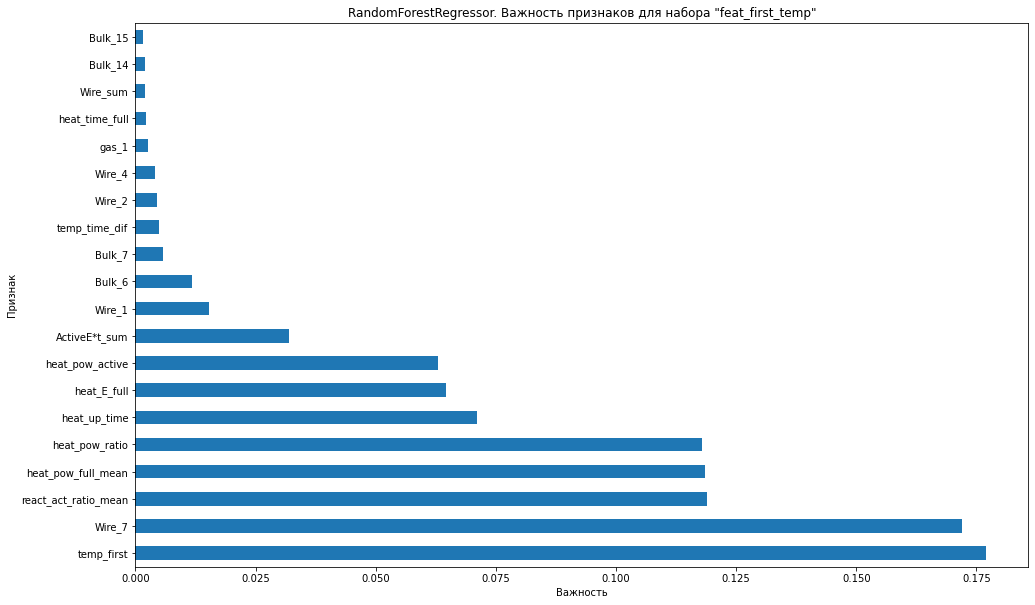

In [122]:
forest_feat_importances.nlargest(20).plot(kind='barh', figsize=(16, 10))
plt.title('RandomForestRegressor. Важность признаков для набора "feat_first_temp"') 
plt.ylabel('Признак')
plt.xlabel('Важность');

In [123]:
display(pd.DataFrame(model_dict).T)
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=True)

,model_name,feat_name,params,model_valid_mae,model_fit_time,model_pred_time,model_test_mae
0,RandomForestRegressor,feat_full,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",5.93993,0.313,0.004,3.756
1,RandomForestRegressor,feat_first_temp,"{'max_depth': 14, 'min_samples_leaf': 2, 'min_...",7.44414,0.474,0,6.33922
2,RandomForestRegressor,feat_first_temp_drop,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",7.5229,0.222,0.01,6.31475
3,RandomForestRegressor,feat_20,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_...",7.43592,0.152,0.01,6.29196
4,RandomForestRegressor,feat_no_temp,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_...",8.49897,0.101,0,7.70739


<a name="65"></a>
### LightGBM

In [124]:
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    model = LGBMRegressor()
    beg_time = datetime.datetime.now()
    b={}
    b['model_name'] = 'LGBMRegressor'
    b['feat_name'] = feat_name_list[i]
    
    parametrs = { 'metric': ['mae'],
                  'boosting_type': ['gbdt'],
                  'learning_rate': [0.05],
                  'n_estimators': [2000, 3000],
                  'max_depth': [3, 10, 14]}
    
    grid = GridSearchCV(model, parametrs, cv=kfold, scoring='neg_mean_absolute_error', iid=True)
    grid.fit(data_train[feat].values, data_train[target].values.ravel())
    b['params'] = grid.best_params_
    model = LGBMRegressor().set_params(**b['params'])
    b['model_valid_mae'] = -cross_val_score(model, data_train[feat].values, data_train[target].values.ravel(), 
                                            cv=kfold, scoring='neg_mean_absolute_error').mean()

    beg_time = datetime.datetime.now()
    model.fit(data_train[feat].values, data_train[target].values.ravel())
    b['model_fit_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    beg_time = datetime.datetime.now()
    model_predicted = model.predict(data_test[feat].values)
    b['model_pred_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    b['model_test_mae'] = mean_absolute_error(data_test[target].values.ravel(), model_predicted)
    model_dict[i] = b

    # сохраним важность признаков        
    if feat == feat_first_temp:
        lgbm_feat_importances = pd.Series(
            model.feature_importances_, index=feat_first_temp)/model.feature_importances_.sum()      

        # Меняем список из 20 наиболее значимых
        feat_20 = rcoef.nlargest(20).index.tolist()
        
    print('test MAE:%.1f' %b['model_test_mae'], 'valid MAE:%.1f' %b['model_valid_mae'], b['model_name'], b['feat_name'])
    print(b['params'])
    i+=1

C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:4.6 valid MAE:5.6 LGBMRegressor feat_full
{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'mae', 'n_estimators': 3000}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:7.3 valid MAE:7.3 LGBMRegressor feat_first_temp
{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'mae', 'n_estimators': 3000}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:6.9 valid MAE:6.7 LGBMRegressor feat_first_temp_drop
{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'mae', 'n_estimators': 3000}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:7.0 valid MAE:6.4 LGBMRegressor feat_20
{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'mae', 'n_estimators': 3000}


C:\Users\Woland\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


test MAE:8.7 valid MAE:8.2 LGBMRegressor feat_no_temp
{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'metric': 'mae', 'n_estimators': 3000}


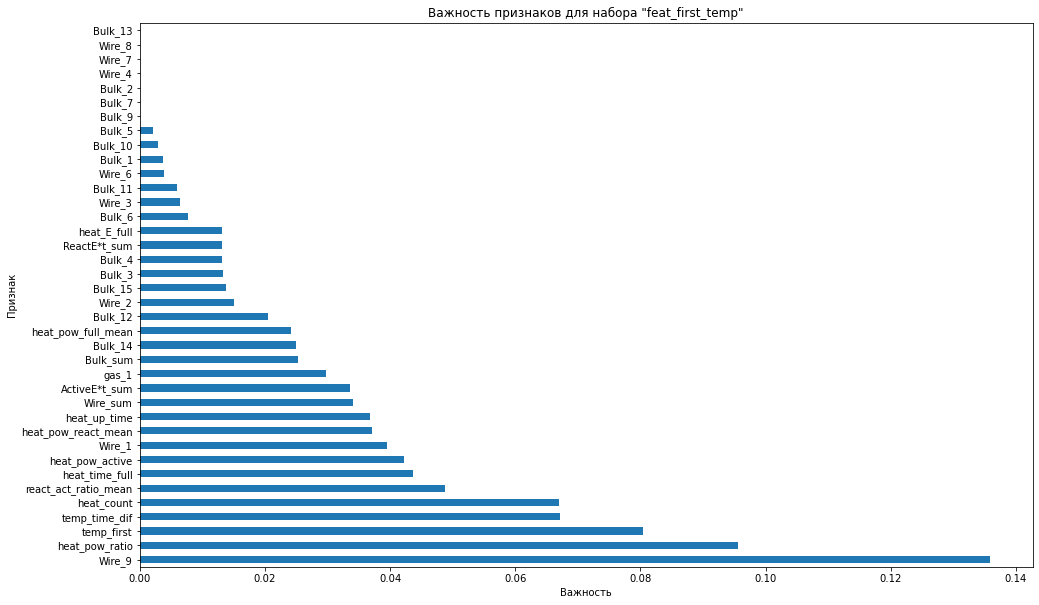

In [125]:
lgbm_feat_importances.nlargest(50).plot(kind='barh', figsize=(16, 10)) #.nlargest(30)
plt.title('Важность признаков для набора "feat_first_temp"') 
plt.ylabel('Признак')
plt.xlabel('Важность');

In [126]:
display(pd.DataFrame(model_dict).T)
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)

,model_name,feat_name,params,model_valid_mae,model_fit_time,model_pred_time,model_test_mae
0,LGBMRegressor,feat_full,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",5.55117,0.141,0.253,4.57386
1,LGBMRegressor,feat_first_temp,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",7.25736,0.808,0.243,7.30945
2,LGBMRegressor,feat_first_temp_drop,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",6.65006,0.385,0.263,6.90827
3,LGBMRegressor,feat_20,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",6.36836,0.638,0.243,7.02982
4,LGBMRegressor,feat_no_temp,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",8.23424,0.484,0.253,8.6745


<a name="66"></a>
### CatBoost

In [ ]:
model_dict={}   #словарь для данных по модели
i=0
for feat in feat_list:
    model = CatBoostRegressor()
    beg_time = datetime.datetime.now()
    b={}
    b['model_name'] = 'CatBoostRegressor'
    b['feat_name'] = feat_name_list[i]
    
    mae = 0
    for tr, val in kfold.split(data_train.index):
        data_tr = data_train.iloc[tr]
        data_val = data_train.iloc[val]
        model = CatBoostRegressor(verbose=1000)
        model.fit(data_tr[feat].values, data_tr[target].values.ravel())
        model_predicted = model.predict(data_val[feat].values)
        mae += mean_absolute_error(data_val[target].values.ravel(), model_predicted)
    b['model_valid_mae'] = mae/5
    
    beg_time = datetime.datetime.now()
    model.fit(data_train[feat].values, data_train[target].values.ravel())
    b['model_fit_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    beg_time = datetime.datetime.now()
    model_predicted = model.predict(data_test[feat].values)
    b['model_pred_time'] = round((datetime.datetime.now()-beg_time).
                                microseconds/1000000, 3) #время в сек. с 3 знаками после запятой
    
    b['model_test_mae'] = mean_absolute_error(data_test[target].values.ravel(), model_predicted)
    model_dict[i] = b

    # сохраним важность признаков
    if feat == feat_first_temp:
        catboost_feat_importances = pd.Series(
            model.feature_importances_, index=feat_first_temp)/model.feature_importances_.sum()

        # Меняем список из 20 наиболее значимых
        feat_20 = rcoef.nlargest(20).index.tolist()
    
    print('test MAE:%.1f' %b['model_test_mae'], 'valid MAE:%.1f' %b['model_valid_mae'], b['model_name'], b['feat_name'])
    i+=1

In [ ]:
catboost_feat_importances.nlargest(50).plot(kind='barh', figsize=(16, 10)) #.nlargest(30)
plt.title('CatBoost. Важность признаков для набора "feat_first_temp"') 
plt.ylabel('Признак')
plt.xlabel('Важность');   

In [ ]:
display(pd.DataFrame(model_dict).T)
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)

<a name="67"></a>
### Сравнение моделей.

In [ ]:
final_table

In [ ]:
pivot_feat_importances = pd.concat([rcoef, tree_feat_importances, forest_feat_importances, 
                                    lgbm_feat_importances, catboost_feat_importances], axis=1)
pivot_feat_importances.columns = ['LR_fi', 'tree_fi', 'forest_fi', 'lgbm_fi', 'catboost_fi']
#pivot_feat_importances

In [ ]:
#pivot_feat_importances.plot(kind='bar', figsize=(16, 10))
#plt.show() 

In [ ]:
pivot_feat_importances.plot(kind='barh',stacked=True, figsize=(16, 14), grid = True)
plt.show()

<a name="7"></a>
## Общий вывод.

***
**Вывод по выполнению проекта:**

В целом работа проведена согласно пунктам плана. При разделении данных не реализована запланированная стратификация (по количеству измерений температуры или количеству нагревов) т.к. улучшения метрики не наблюдалось.

Удивили низкие значения средней абсолютной ошибки у линейной регресии.

***
**Вывод по данным:**

В подготовленном к обучению наборе данных информация по 2345 партиям и 38 (+1 целевой) признаков.
Для создания прототипа модели достаточно, но для отладки и уверенного обучения моделей количество партий необходимо увеличить.

Входящие данные имеют значительное количество пропусков: 
* отсутствующие значения температуры для партий 2500-3241 (есть только 1 значение температуры) - около 23%

Встречаются экстремальные значения(выбросы): 
* реактивная мощность "-715" в партии 2116
* партии длительностью более 2 ч. 14 мин.: 44, 46, 118, 638, 641, 801, 1513, 1689, 1880, 1881, 1958, 2107, 2108 - 0,5%
* партии длительностью менее 6 мин.: 151, 600, 720, 744, 800, 812, 977, 1105, 1116, 1334, 1381, 2254, 2486 - 0,5%

Редкие признаки: 
* данные о подаче сыпучих материалов из "Bulk_8" только в партии 1786 
* данные о подаче проволочных материалов из "Wire_5" только в партии 2567

Ошибки требующие комментариев со стороны заказчика:
* непоследовательные измерения температуры разных партий - около 10-15 участков по 3-4 партии (например партии 44-48)
* высокое значение подачи сыпучих материалов (Bulk 12 и Bulk_sum) в партии 303
* для некоторых партий отсутствуют данные о подаче сыпучих и проволочных материалов

(дополнительно см. разделы: 
* [Изучение и подготовка данных](#32), 
* [Удаление данных с ошибками](#328), 
* [Создание дополнительных признаков](#33), 
* [Исследовательский анализ данных](#411)

***
**Вывод по обучению и тестированию моделей:**

Из условий задачи не ясно планирует ли заказчик в дальнейшем проводить измерения температуры в процессе обработки стали. Поэтому модели проверялись на нескольких наборах признаков. После уточнения условий из всех признаков сформированных из данных о температуре было решено оставить только начальное значение температуры. Поэтому результаты полученные на полном наборе признаков в расчет не берем.

Исследованы 5 моделей. Наименьшее значение средней абсолютной ошибки на тестовых данных (около 5,6 градусов) у CatBoostRegressor и линейной регрессии. 

Лучшее время обучения и предсказания ожидаемо у линейной регресии, при этом для данных с уменьшеным количеством признаков ошибка растет меньше у CatBoostRegressor (для 20 признаков средняя ошибка 5,9 градусов)

Модели для обучения используют разные признаки. 

Информация по исследованным моделям в [сводной таблице](#67).

Снизить показатели средней ошибки моделей вероятно позволят следующие мероприятия: 

* более широкий подбор параметров моделей
* подбор оптимальных наборов признаков (по значимости и зависимости между собой)
* использование в моделях признаков на основании времени первого измерения температуры (в какой момент процесса производится в данной партии) и времени внесения добавок
* введение дополнительного параметра (сдвига) в связи с "инертностью" передачи тепловой энергии при нагреве и соответствующего запаздывания изменения температуры (в какой момент получены данные о целевом признаке)
* более "въедлевая" работа с выбросами и пропусками

Таким образом на окончательный выбор модели влияют:

* простота, точность и надежность получения используемых моделью признаков
* точность и стабильность предсказания
* скорость обучения и предсказания модели (если важно)